# Schema Usage

The schema does not actually store any data.  Instead, it is an interface which allows us to interact with numpy/torch tensors in a semantic manner.  It lets us convert between storage vectors (i.e. how we store the building parameters numerically on disk), simulation objects (e.g. Archetypal Templates and PyUmi Shoeboxes) and machine learning model imports (i.e. torch tensors with full hourly schedule data).

## Notebook setup

We need some jank to get relative imports working.

In [36]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [37]:
import matplotlib.pyplot as plt
import numpy as np

## Initialize the Schema

In [38]:
from schema import Schema, ShoeboxGeometryParameter, BuildingTemplateParameter, WhiteboxSimulation
schema = Schema()

Let's see what's in the schema:

In [39]:
schema.parameter_names

['batch_id',
 'variation_id',
 'base_template_lib',
 'base_template',
 'base_epw',
 'width',
 'height',
 'facade_2_footprint',
 'perim_2_footprint',
 'roof_2_footprint',
 'footprint_2_ground',
 'shading_fact',
 'wwr_n',
 'wwr_e',
 'wwr_s',
 'wwr_w',
 'orientation',
 'LightingPowerDensity',
 'EquipmentPowerDensity',
 'PeopleDensity',
 'FacadeRValue',
 'RoofRValue',
 'PartitionRValue',
 'SlabRValue',
 'FacadeMass',
 'RoofMass',
 'PartitionMass',
 'SlabMass',
 'schedules_seed',
 'schedules']

We can access a schema parameter from the schema with list indexing:

In [40]:
print(schema["width"])
print(schema["schedules"])
print(schema["orientation"])

---width---
shape_storage=(1,), shape_ml=(1,), dtype=scalar
Width [m]
---schedules---
shape_storage=(8, 16), shape_ml=(8, 8760), dtype=matrix
A matrix in the storage vector with operations to apply to schedules; a matrix of timeseries in ml vector
---orientation---
shape_storage=(1,), shape_ml=(4,), dtype=onehot
Shoebox Orientation


We see that each parameter may have multiple different lengths in the storage vector and ML vector.

We can also print a summary of the whole schema:

In [41]:
print(schema)

-------- Schema --------
---- batch_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 0->1 / location ml: 0->0

---- variation_id ----
shape storage: (1,) / shape ml: (0,)
location storage: 1->2 / location ml: 0->0

---- base_template_lib ----
shape storage: (1,) / shape ml: (0,)
location storage: 2->3 / location ml: 0->0

---- base_template ----
shape storage: (1,) / shape ml: (0,)
location storage: 3->4 / location ml: 0->0

---- base_epw ----
shape storage: (1,) / shape ml: (0,)
location storage: 4->5 / location ml: 0->0

---- width ----
shape storage: (1,) / shape ml: (1,)
location storage: 5->6 / location ml: 0->1

---- height ----
shape storage: (1,) / shape ml: (1,)
location storage: 6->7 / location ml: 1->2

---- facade_2_footprint ----
shape storage: (1,) / shape ml: (1,)
location storage: 7->8 / location ml: 2->3

---- perim_2_footprint ----
shape storage: (1,) / shape ml: (1,)
location storage: 8->9 / location ml: 3->4

---- roof_2_footprint ----
shape storage: (

We see that the length of the storage vector is significantly smaller than the length the vector the ML model will see.

## Generating new design vectors in storage space

First let's generate a new, empty design vector, and update the Roof R-Value, and then check that it updated correctly:

In [42]:
storage_vector = schema.generate_empty_storage_vector()
schema.update_storage_vector(storage_vector=storage_vector, parameter="RoofRValue", value=25)
schema["RoofRValue"].extract_storage_values(storage_vector)

25.0

If we print out the full vector, we should be able to see th 25 and a whole bunch of zeros:

In [43]:
print(storage_vector)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. 25.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Let's create a new batch of designs:

In [44]:
batch_size = 20
storage_batch = schema.generate_empty_storage_batch(batch_size)
storage_batch.shape

(20, 157)

Great, we see that it has 20 design vectors with 151 values each.

Let's try updating all of the facade R-values values in a batch with the same value:

In [45]:
schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=14)
schema["FacadeRValue"].extract_storage_values_batch(storage_batch)

array([[14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.]])

Now let's try updating an entire batch with random values.  We can also unnormalize the uniform random variable into the desired range:

In [46]:
parameter = "SlabRValue"
n = batch_size
shape = (n, *schema[parameter].shape_storage)
values = np.random.rand(*shape) # create a random sample with appropriate shape
values = schema[parameter].unnormalize(values) # schema parameter must be a numeric type with min/max defined for unnormalize to work
schema.update_storage_batch(storage_batch, parameter=parameter, value=values)
schema[parameter].extract_storage_values_batch(storage_batch)

array([[13.75555624],
       [12.99750627],
       [ 0.82032116],
       [ 3.82719871],
       [ 6.45852444],
       [ 1.84712761],
       [13.00675875],
       [ 7.04552552],
       [ 2.70067468],
       [ 0.50608678],
       [14.25081783],
       [10.04538506],
       [11.67761398],
       [ 9.64298854],
       [14.7662466 ],
       [10.21390114],
       [ 1.98175302],
       [ 6.60543521],
       [13.89003287],
       [11.81778673]])

Finally, let's try updating just a subset of the batch by using the `index` parameter:

*nb: we can also use an int instead of a tuple for `index` to only update a single vector's parameter*

In [47]:
start = 2
n = 8
end = start + n
parameter = "PartitionRValue"
shape = (n, *schema[parameter].shape_storage)
values = np.random.rand(*shape) # create a random sample with appropriate shape

schema.update_storage_batch(storage_batch, index=(start,end), parameter=parameter, value=values)
schema[parameter].extract_storage_values_batch(storage_batch) 

array([[0.        ],
       [0.        ],
       [0.05444635],
       [0.82962058],
       [0.11401286],
       [0.76654051],
       [0.20856012],
       [0.43860779],
       [0.50727226],
       [0.5889278 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

A useful technique will be to start with a small batch, and then duplicate it in concatenations along `axis=0` as we build up our mixed grid/hypercube/random samples.  Let's start by creating a new batch with a single vector.

In [48]:
storage_batch = schema.generate_empty_storage_batch(1)
storage_batch.shape

(1, 157)

Now let's say some baseline parameters (e.g. pulled from ResStock)

In [49]:
schema.update_storage_batch(storage_batch, parameter="FacadeRValue", value=20)
schema.update_storage_batch(storage_batch, parameter="RoofRValue", value=30)
schema.update_storage_batch(storage_batch, parameter="LightingPowerDensity", value=7.2)
schema.update_storage_batch(storage_batch, parameter="base_template_lib", value=0)
schema.update_storage_batch(storage_batch, parameter="base_template", value=2)
storage_batch = np.concatenate([storage_batch for _ in range(4)], axis=0)
storage_batch

array([[ 0. ,  0. ,  0. ,  2. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  7.2,  0. ,  0. , 20. , 30. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. , 

Now let's set the orientations:

In [50]:
values = np.arange(4).reshape(-1,1)
parameter = "orientation"
schema.update_storage_batch(storage_batch, parameter=parameter, value=values)
schema[parameter].extract_storage_values_batch(storage_batch)

array([[0.],
       [1.],
       [2.],
       [3.]])

Looks good!  Now let's stack this up and begin generating some geometric variations.

In [51]:
orientations_per_base = 4
geometric_variations_per_orientation = 5

In [52]:
storage_batch = np.repeat(storage_batch, geometric_variations_per_orientation, axis=0)
storage_batch.shape

(20, 157)

In [53]:
schema["orientation"].extract_storage_values_batch(storage_batch)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

Looks good!  let's start populating this: if we wanted to use repeating values, we could do nested loops:

In [54]:
n = geometric_variations_per_orientation # how many design vectors in this mini batch
for i in range(orientations_per_base):
	start = i*n # where this mini batch starts in the parent batch
	end = start + n # where this mini batch ends in the parent batch
	for j,parameter in enumerate(schema.parameters):
		if isinstance(parameter, ShoeboxGeometryParameter):
			name = parameter.name
			shape = parameter.shape_storage
			np.random.seed(j+20923) # arbitrary but reliable seed
			values = np.random.rand(n, *shape) 
			values = parameter.unnormalize(values)
			schema.update_storage_batch(storage_batch, index=(start,end), parameter=name, value=values)


In [55]:
schema["wwr_e"].extract_storage_values_batch(storage_batch)

array([[0.40193869],
       [0.5068512 ],
       [0.05550449],
       [0.61793909],
       [0.97010965],
       [0.40193869],
       [0.5068512 ],
       [0.05550449],
       [0.61793909],
       [0.97010965],
       [0.40193869],
       [0.5068512 ],
       [0.05550449],
       [0.61793909],
       [0.97010965],
       [0.40193869],
       [0.5068512 ],
       [0.05550449],
       [0.61793909],
       [0.97010965]])

In [56]:
schema["width"].extract_storage_values_batch(storage_batch)

array([[6.29478162],
       [8.1783848 ],
       [7.71875683],
       [8.13812409],
       [8.49262696],
       [6.29478162],
       [8.1783848 ],
       [7.71875683],
       [8.13812409],
       [8.49262696],
       [6.29478162],
       [8.1783848 ],
       [7.71875683],
       [8.13812409],
       [8.49262696],
       [6.29478162],
       [8.1783848 ],
       [7.71875683],
       [8.13812409],
       [8.49262696]])

Great, these are repeating correctly!  Now, suppose we want to just slightly perturb all of these so that they aren't perfectly repeating, but are close to repeating:

In [57]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
	if isinstance(parameter, ShoeboxGeometryParameter):
		name = parameter.name
		shape = parameter.shape_storage
		perturbations = np.random.rand(n,*shape)*0.2 - 0.1
		values = parameter.extract_storage_values_batch(storage_batch)
		values += perturbations
		schema.update_storage_batch(storage_batch,parameter=name,value=values)

schema["width"].extract_storage_values_batch(storage_batch)

array([[6.31768741],
       [8.16401562],
       [7.69802477],
       [8.12204568],
       [8.5925901 ],
       [6.35466394],
       [8.13898185],
       [7.79176962],
       [8.15827553],
       [8.48304531],
       [6.27396719],
       [8.19034802],
       [7.8071466 ],
       [8.14228871],
       [8.50921745],
       [6.31695304],
       [8.13701467],
       [7.81001684],
       [8.17402808],
       [8.46220546]])

Great!  We see that they are close to their previous values, but not identical.  

Alternatively, we might prefer to simply use fully random geometric variations for all of our orientation duplicates, rather than repeating the geometry across orientations:

In [58]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
	if isinstance(parameter, ShoeboxGeometryParameter):
		name = parameter.name
		shape = parameter.shape_storage
		values = np.random.rand(n,*shape)
		values = parameter.unnormalize(values)
		schema.update_storage_batch(storage_batch,parameter=name,value=values)

schema["width"].extract_storage_values_batch(storage_batch)

array([[10.82209539],
       [ 7.57764369],
       [ 4.44701543],
       [11.49733639],
       [ 6.75531458],
       [ 8.77008879],
       [ 8.29771713],
       [ 5.93074429],
       [ 9.20371717],
       [ 7.50698059],
       [ 4.55912467],
       [ 6.83968463],
       [ 4.04239211],
       [11.86941893],
       [ 4.67267898],
       [ 5.92858978],
       [ 6.91735153],
       [ 4.96718329],
       [ 3.17630159],
       [11.89581458]])

Later on in this file, we will be inspecting template parameters as well, so let's just arbitrarily set some building template parameters for each design:

In [59]:
n = storage_batch.shape[0]
for i,parameter in enumerate(schema.parameters):
	if isinstance(parameter, BuildingTemplateParameter):
		name = parameter.name
		shape = parameter.shape_storage
		values = np.random.rand(n,*shape)
		values = parameter.unnormalize(values)
		schema.update_storage_batch(storage_batch,parameter=name,value=values)

schema["LightingPowerDensity"].extract_storage_values_batch(storage_batch)

array([[16.0987722 ],
       [ 0.54685159],
       [ 9.92263323],
       [ 0.58972666],
       [ 5.75351925],
       [ 2.69068308],
       [ 4.6627841 ],
       [ 3.36097484],
       [17.97861308],
       [17.19523042],
       [18.69919415],
       [15.33366732],
       [18.12874707],
       [11.99523585],
       [ 8.32273254],
       [ 1.34838942],
       [17.17378608],
       [18.39893199],
       [14.52133785],
       [ 1.34805487]])

Suppose this was our finished batch.  We can save it to an HDF5 file.  Let's say this was building 23 from our ResStock database.

In [60]:
import h5py
from storage import upload_to_bucket

In [61]:
# Update the building IDs
batch_id = 23 # suppose this is the base building we are drawing from
n = storage_batch.shape[0]
variation_ids = np.arange(n)
schema.update_storage_batch(storage_batch,parameter="batch_id",value=batch_id)
schema.update_storage_batch(storage_batch,parameter="variation_id",value=variation_ids)

# Write to an HDF5 file
slug = f"batch_{batch_id:05d}.hdf5"
outfile = f"./data/{slug}"
with h5py.File(outfile,"w") as f:
    f.create_dataset(name="storage_vectors", shape=storage_batch.shape, dtype=storage_batch.dtype, data=storage_batch)

# upload to cloud bucket for easy backup
destination = f"demo-batch-data/{slug}"
upload_to_bucket(destination, outfile)


## Simulation

Now let's suppose you want to simulate a design vector.  Let's open up an HDF5 file and read in only the first storage vector to get started.

In [62]:
batch_id = 23
slug = f"batch_{batch_id:05d}.hdf5"
outfile = f"./data/hdf5/{slug}"
storage_vector = None
with h5py.File(outfile,'r') as f:
    storage_vector = f["storage_vectors"][0]

schema["batch_id"].extract_storage_values(storage_vector), schema["variation_id"].extract_storage_values(storage_vector)

(23.0, 0.0)

Great! Looks like we successfully opened the 0th design variation from batch 23.

Now let's create a simulation object for this storage vector:

In [63]:
whitebox_sim = WhiteboxSimulation(schema, storage_vector)

INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.


Now we can take a look at the semantic objects that have been configured!

In [64]:
print(whitebox_sim.shoebox_config.facade_2_footprint)
print(whitebox_sim.shoebox_config.width)
print(whitebox_sim.template.Perimeter.Loads.LightingPowerDensity)
print(whitebox_sim.template.Core.Loads.PeopleDensity)
print(whitebox_sim.shoebox)

1.902105808817122
10.822095385622553
16.098772201515562
0.47917882744739826
89493fa4-df2e-11ed-b987-841b77d62e9a.idf


Great!  Jeez I'm saying that a lot in this notebook.

Let's run an actual simulation.

In [65]:
res_hourly, res_monthly = whitebox_sim.simulate()

C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 1.00it [00:00, 31.7it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 2.00it [00:00, 19.8it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 3.00it [00:00, 29.4it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.062


ExpandObjects Started.
 Begin reading Energy+.idd file.
 Done reading Energy+.idd file.
ExpandObjects Finished. Time:     0.062


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 4.00it [00:00, 29.4it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:ExpandObjects completed in 0.10 seconds
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 4.00it [00:00, 36.3it/s]


ExpandObjects completed in 0.10 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 1it [00:00, 58.56it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50


Simulation started
EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50


C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 2it [00:00, 10.71it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 3it [00:00, 15.89it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 4it [00:00, 15.89it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 5it [00:00, 15.89it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 6it [00:00, 15.89it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 7it [00:00, 15.89it/s]INFO:89493fa4-df2e-11ed-b987-841b

Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 17it [00:00, 54.85it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 18it [00:00, 54.85it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 19it [00:00, 54.85it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 20it [00:00, 38.67it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 21it [00:00, 38.67it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017

Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2017


C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 22it [00:00, 38.67it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 23it [00:00, 38.67it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 24it [00:00, 31.87it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 25it [00:00, 31.87it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 26it [00:00, 31.87it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1


Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 27it [00:00, 31.87it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 28it [00:00, 28.25it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 29it [00:00, 28.25it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 30it [00:00, 28.25it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 31it [00:01, 28.25it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017

Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 33it [00:01, 26.56it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 34it [00:01, 26.56it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 35it [00:01, 26.56it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 36it [00:01, 25.61it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 37it [00:01, 25.61it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017

Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 39it [00:01, 25.61it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 40it [00:01, 24.96it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 41it [00:01, 24.96it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 42it [00:01, 24.96it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 43it [00:01, 24.96it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017

Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/28/2017


C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 44it [00:01, 23.91it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 45it [00:01, 23.91it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 46it [00:01, 23.91it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 47it [00:01, 23.91it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 48it [00:01, 23.24it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1


Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 49it [00:01, 23.24it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 50it [00:01, 23.24it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 51it [00:01, 23.24it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 52it [00:01, 25.64it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 89493fa4-df2e-11ed-b987-841b77d62e9a.idf: 53it [00:01, 25.64it/s]INFO:89493fa4-df2e-11ed-b987-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energ

Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  1.89sec
EnergyPlus Completed in 1.93 seconds


INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']


Looks like it simulated successfully! Let's confirm by taking a look at the the tables.

In [66]:
res_hourly.head()

IndexGroup                                               System  \
KeyValue            BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM   
Name                 Zone Ideal Loads Zone Total Heating Energy   
2018-01-01 00:00:00                                1.493033e+06   
2018-01-01 01:00:00                                3.851080e+05   
2018-01-01 02:00:00                                1.080300e+05   
2018-01-01 03:00:00                                1.773405e+03   
2018-01-01 04:00:00                                0.000000e+00   

IndexGroup                                                      \
KeyValue                                                         
Name                Zone Ideal Loads Zone Total Cooling Energy   
2018-01-01 00:00:00                               5.379377e-08   
2018-01-01 01:00:00                               1.102478e-08   
2018-01-01 02:00:00                               4.316547e-09   
2018-01-01 03:00:00                               1.057154e-10   
2018-01-01 04:00:00                               0.000000e+00   

IndexGroup                                                      \
KeyValue            BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM   
Name                Zone Ideal Loads Zone Total Heating Energy   
2018-01-01 00:00:00                              321196.580949   
2018-01-01 01:00:00                              454137.063797   
2018-01-01 02:00:00                              499129.456650   
2018-01-01 03:00:00                              509575.470155   
2018-01-01 04:00:00                              506742.411238   

IndexGroup                                                      
KeyValue                                                        
Name                Zone Ideal Loads Zone Total Cooling Energy  
2018-01-01 00:00:00                               1.223981e-08  
2018-01-01 01:00:00                               2.138449e-08  
2018-01-01 02:00:00                               1.608953e-08  
2018-01-01 03:00:00                               1.176659e-09  
2018-01-01 04:00:00                               0.000000e+00

In [67]:
res_monthly

IndexGroup                                      System  \
KeyValue   BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM   
Name        Zone Ideal Loads Zone Total Heating Energy   
2018-01-01                                2.002599e+09   
2018-02-01                                1.378436e+09   
2018-03-01                                8.220652e+08   
2018-04-01                                3.042288e+08   
2018-05-01                                6.058682e+07   
2018-06-01                                0.000000e+00   
2018-07-01                                0.000000e+00   
2018-08-01                                0.000000e+00   
2018-09-01                                2.944630e+06   
2018-10-01                                9.954352e+07   
2018-11-01                                7.306875e+08   
2018-12-01                                1.914352e+09   

IndexGroup                                             \
KeyValue                                                
Name       Zone Ideal Loads Zone Total Cooling Energy   
2018-01-01                               1.668717e+09   
2018-02-01                               2.483798e+09   
2018-03-01                               3.124138e+09   
2018-04-01                               2.238335e+09   
2018-05-01                               2.915479e+09   
2018-06-01                               3.745359e+09   
2018-07-01                               4.442171e+09   
2018-08-01                               4.801488e+09   
2018-09-01                               4.636557e+09   
2018-10-01                               3.158846e+09   
2018-11-01                               1.831848e+09   
2018-12-01                               1.267573e+09   

IndexGroup                                             \
KeyValue   BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM   
Name       Zone Ideal Loads Zone Total Heating Energy   
2018-01-01                               5.319640e+08   
2018-02-01                               3.602359e+08   
2018-03-01                               2.304835e+08   
2018-04-01                               1.041267e+08   
2018-05-01                               2.145698e+07   
2018-06-01                               0.000000e+00   
2018-07-01                               0.000000e+00   
2018-08-01                               0.000000e+00   
2018-09-01                               9.341114e+05   
2018-10-01                               4.094756e+07   
2018-11-01                               2.624657e+08   
2018-12-01                               5.294453e+08   

IndexGroup                                             
KeyValue                                               
Name       Zone Ideal Loads Zone Total Cooling Energy  
2018-01-01                               1.581283e+08  
2018-02-01                               2.539872e+08  
2018-03-01                               3.894507e+08  
2018-04-01                               2.718182e+08  
2018-05-01                               4.042504e+08  
2018-06-01                               5.491771e+08  
2018-07-01                               6.412566e+08  
2018-08-01                               6.582920e+08  
2018-09-01                               5.889141e+08  
2018-10-01                               3.668574e+08  
2018-11-01                               1.963134e+08  
2018-12-01                               1.176675e+08

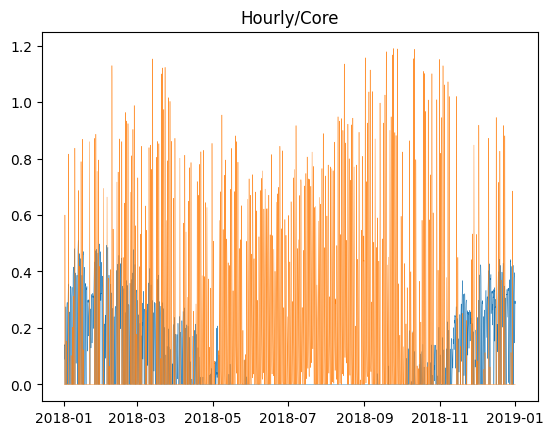

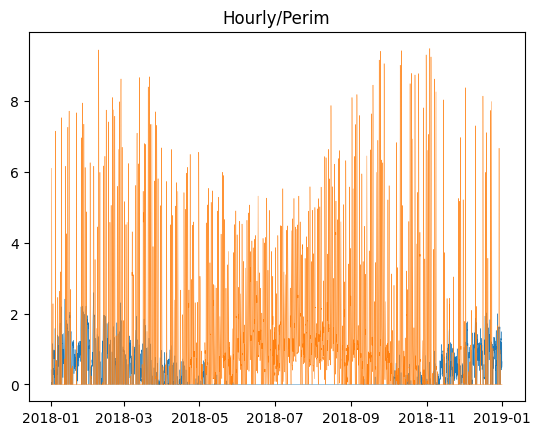

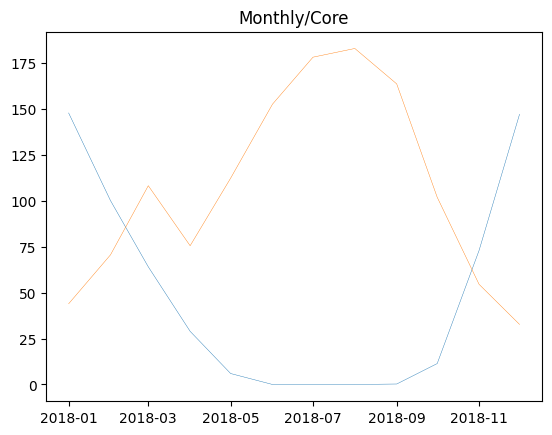

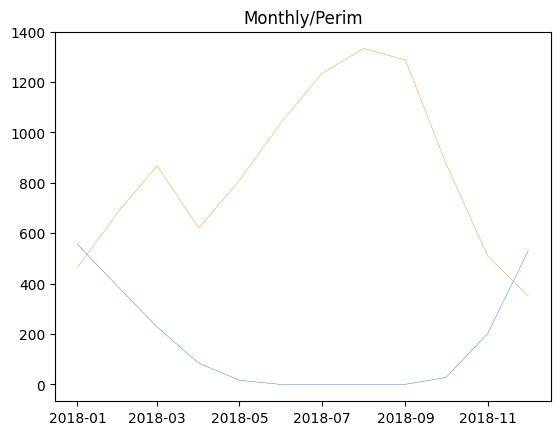

In [68]:
fig = plt.figure()
plt.plot(res_hourly["System"]["BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM"]*2.777e-7, linewidth=0.3)
txt = plt.title("Hourly/Core")
fig = plt.figure()
plt.plot(res_hourly["System"]["BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM"]*2.777e-7, linewidth=0.3)
txt = plt.title("Hourly/Perim")
fig = plt.figure()
plt.plot(res_monthly["System"]["BLOCK CORE STOREY 0 IDEAL LOADS AIR SYSTEM"]*2.777e-7, linewidth=0.3)
txt = plt.title("Monthly/Core")
fig = plt.figure()
plt.plot(res_monthly["System"]["BLOCK PERIM STOREY 0 IDEAL LOADS AIR SYSTEM"]*2.777e-7, linewidth=0.3)
txt = plt.title("Monthly/Perim")

## Batch Simulation

Now let's take a look at simulating a whole batch.

First, we need to instantiate the batch simulator.  This configures an object which will automatically handle identifying and opening the correct storage vector batch, and can automatically run simulations in parallel and write results to a new HDF5 file.  It will also automatically upload the results files to the cloud bucket.

*nb: `simulate.py` can be called from the CLI in order to facilitate easily launching many Batches simultaneously from many processes running on multiple servers, i.e.* `python simulate.py <batch_id> <n of processes>`

In [69]:
from simulate import BatchSimulator
batch_runner = BatchSimulator(schema, batch_id=23, processes=5)

INFO:Batch Simulator:--------- Batch Simulation ---------
INFO:Batch Simulator:Batch ID: 23
INFO:Batch Simulator:Opening HDF5 storage batch file for batch 23...
INFO:Batch Simulator:Loaded BATCH:23, which has 20 design vectors
INFO:Batch Simulator:Building parallel dict config for BATCH:23...


To simulate, all we need to do is call the `run` method!

In [70]:
batch_runner.run()

INFO:Batch Simulator:Launching parallel processing for BATCH:23 with 5 p.processors...
simulate:   0%|          | 0.00/20.0 [00:00<?, ?runs/s]INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledV

ExpandObjects Started.
ExpandObjects Started.
 Begin reading Energy+.idd file.
 Begin reading Energy+.idd file.


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 2.00it [00:00, 15.2it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 2.00it [00:00, 13.6it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 2.00it [00:00, 12.4it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 2.00it [00:00, 11.5it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 3.00it [00:00, 17.0it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 3.00it [00:00, 17.0

ExpandObjects Started.
ExpandObjects Started.
ExpandObjects Started.
 Done reading Energy+.idd file.
 Done reading Energy+.idd file.
 Begin reading Energy+.idd file.
 Begin reading Energy+.idd file.


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 3.00it [00:00, 17.0it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 3.00it [00:00, 17.0it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.031
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 4.00it [00:00, 17.0it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.094
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 4.00it [00:00, 17.0it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 4.00it [00:00, 17.0it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11e

 Begin reading Energy+.idd file.
ExpandObjects Finished. Time:     0.031
ExpandObjects Finished. Time:     0.094
 Done reading Energy+.idd file.
 Done reading Energy+.idd file.
 Done reading Energy+.idd file.


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 4.00it [00:00, 17.0it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:ExpandObjects completed in 0.24 seconds
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 3.00it [00:00, 16.1it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:ExpandObjects completed in 0.24 seconds
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 3.00it [00:00, 16.1it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.062
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 3.00it [00:00, 16.1it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.047
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 4.00it [00:00, 15.9it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.062
C:\EnergyPlusV9-2-0\ExpandObjects.E

ExpandObjects completed in 0.24 seconds
ExpandObjects completed in 0.24 seconds
ExpandObjects Finished. Time:     0.062
ExpandObjects Finished. Time:     0.047
ExpandObjects Finished. Time:     0.062
ExpandObjects completed in 0.26 seconds
ExpandObjects completed in 0.25 seconds
ExpandObjects completed in 0.25 seconds


INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:ExpandObjects completed in 0.25 seconds

C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 4.00it [00:00, 12.9it/s]
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 4.00it [00:00, 13.1it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 1it [00:00, 13.95it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 1it [00:00, 12.01it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50


Simulation started
EnergyPlus Starting
Simulation started
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50


C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:EnergyPlus Starting


EnergyPlus Starting


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 2it [00:00, 12.42it/s]

EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50
Simulation started
Simulation started
Simulation started
EnergyPlus Starting
EnergyPlus Starting


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 1it [00:00,  9.23it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 2it [00:00, 14.18it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50


EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 1it [00:00,  8.30it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 2it [00:00,  8.30it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Adjusting Air System Sizing


EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:50
Adjusting Air System Sizing


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 2it [00:00,  8.30it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 2it [00:00,  8.30it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 2it [00:00,  8.30it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 3it [00:00,  9.83it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 2it [00:00,  8.30it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 2it [00:00,  9.23it/s]

Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Adjusting Air System Sizing
Reporting Surfaces
Adjusting Standard 62.1 Ventilation Sizing
Beginning Primary Simulation


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 2it [00:00,  8.30it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 2it [00:00,  8.30it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 7it [00:00, 19.78it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 3it [00:00,  9.12it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Adjusting Air System Sizing


Initializing Simulation
Adjusting Air System Sizing
Adjusting Air System Sizing


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 3it [00:00,  9.12it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 3it [00:00,  9.12it/s]

Adjusting Air System Sizing
Reporting Surfaces


INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 3it [00:00,  9.12it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Initializing New Environment Parameters
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 8it [00:00, 16.44it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 4it [00:00,  9.12it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 4it [00:00,  9.12it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 4it [00:00,  9.12it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlu

Initializing New Environment Parameters
Adjusting Standard 62.1 Ventilation Sizing
Adjusting Standard 62.1 Ventilation Sizing
Adjusting Standard 62.1 Ventilation Sizing
Beginning Primary Simulation
Initializing Simulation
Warming up {1}


INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 5it [00:00, 11.10it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 5it [00:00, 11.10it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 5it [00:00, 11.10it/s]

Initializing Simulation
Initializing Simulation
Initializing New Environment Parameters


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 5it [00:00, 11.10it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Initializing New Environment Parameters
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 5it [00:00, 10.12it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Warming up {2}
simulate:   0%|          | 0.00/20.0 [00:03<?, ?runs/s]

Warming up {2}
Reporting Surfaces


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 8it [00:00, 13.76it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 10it [00:00, 14.73it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 6it [00:00, 10.76it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 6it [00:00, 10.76it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 6it [00:00, 10.76it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 6it [00:00, 10.76it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Beginning Primary Simulation
             

Reporting Surfaces
Reporting Surfaces
Warming up {1}
Warming up {3}
Beginning Primary Simulation


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 6it [00:00, 10.76it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 7it [00:00, 10.03it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 11it [00:00, 14.73it/s]

Beginning Primary Simulation
Beginning Primary Simulation
Warming up {2}


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 7it [00:00, 10.03it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Warming up {2}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 7it [00:00, 10.91it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Warming up {4}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 12it [00:00, 13.10it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Initializing New Environment Parameters


Warming up {4}
Initializing New Environment Parameters


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 7it [00:00, 10.03it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Initializing New Environment Parameters
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 8it [00:00, 10.03it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Initializing New Environment Parameters
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 8it [00:00, 10.03it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 8it [00:00, 10.03it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 8it [00:00, 10.03it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 8it [00:00, 10.03it/s]

Initializing New Environment Parameters
Initializing New Environment Parameters
Warming up {3}
Warming up {5}
Warming up {1}
Warming up {1}


INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 9it [00:00, 10.63it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 9it [00:00, 10.63it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Warming up {4}
simulate:   0%|          | 0.00/20.0 [00:04<?, ?runs/s]

Warming up {1}
Warming up {4}
Warming up {6}


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 9it [00:00, 10.63it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 9it [00:00, 10.63it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Warming up {2}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 9it [00:00, 10.63it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Warming up {2}


Warming up {2}
Warming up {2}


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 10it [00:00, 10.63it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Warming up {2}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 10it [00:00, 10.63it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 10it [00:01, 10.63it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 10it [00:01, 10.63it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 10it [00:01, 10.63it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 11it [00:01, 11.08it/s]

Warming up {2}
Warming up {5}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Warming up {3}
Warming up {3}
Warming up {3}


INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 11it [00:01, 11.08it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 11it [00:01, 11.26it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 16it [00:01, 12.33it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Warming up {4}
                                                                                                    

Warming up {6}
Updating Shadowing Calculations, Start Date=01/21/2017
Warming up {4}


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 11it [00:01, 11.08it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Warming up {4}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 12it [00:01, 11.08it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Warming up {4}
                                                                                                    

Warming up {4}
Warming up {4}


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 12it [00:01, 11.08it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 12it [00:01, 11.08it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 12it [00:01, 11.08it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 12it [00:01, 11.08it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 13it [00:01, 11.31it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 13it [00:01, 11.31it/s]INFO:8bcb0266-df2e-11

Starting Simulation at 01/01/2017 for RUN PERIOD 1
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Warming up {5}
Warming up {5}
Warming up {5}
Updating Shadowing Calculations, Start Date=01/21/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 13it [00:01, 11.42it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 13it [00:01, 11.31it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 13it [00:01, 11.31it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 14it [00:01, 11.42it/s]

Updating Shadowing Calculations, Start Date=02/10/2017
Warming up {6}
Warming up {6}
Warming up {6}


                                                       INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 14it [00:01, 11.31it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
simulate:   0%|          | 0.00/20.0 [00:04<?, ?runs/s]

Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Continuing Simulation at 02/10/2017 for RUN PERIOD 1


                                                       INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 14it [00:01, 11.31it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 14it [00:01, 11.31it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 15it [00:01, 11.53it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 15it [00:01, 11.53it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-

Starting Simulation at 01/01/2017 for RUN PERIOD 1
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017
Updating Shadowing Calculations, Start Date=03/02/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 15it [00:01, 11.59it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 20it [00:01, 11.84it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 15it [00:01, 11.53it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 16it [00:01, 11.18it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 16it [00:01, 11.18it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD

Updating Shadowing Calculations, Start Date=01/21/2017
Updating Shadowing Calculations, Start Date=01/21/2017
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 16it [00:01, 11.18it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 16it [00:01, 11.18it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 16it [00:01, 11.08it/s]

Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Continuing Simulation at 01/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 16it [00:01, 11.18it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 16it [00:01, 11.18it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 17it [00:01, 11.46it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 20it [00:01, 12.40it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 17it [00:01, 10.55it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017

Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 17it [00:01, 10.56it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
                                                       INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 17it [00:01, 10.55it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 18it [00:01, 10.55it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
                                                                                                    

Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 18it [00:01, 10.55it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 18it [00:01, 10.55it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
                                                                                                    

Updating Shadowing Calculations, Start Date=02/10/2017
Updating Shadowing Calculations, Start Date=03/22/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 18it [00:01, 10.55it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 19it [00:01, 12.09it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 22it [00:01, 12.42it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 19it [00:01, 11.09it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 19it [00:01, 11.09it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C

Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 20it [00:01, 11.09it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 20it [00:01, 11.09it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 20it [00:01, 11.09it/s]

Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=05/01/2017


INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 20it [00:01, 11.09it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1


Continuing Simulation at 03/02/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 20it [00:01, 11.09it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 24it [00:01, 12.69it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 21it [00:01, 11.35it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 21it [00:01, 11.37it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 21it [00:01, 11.37it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\

Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=03/22/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 22it [00:02, 11.37it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 22it [00:02, 11.37it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 22it [00:02, 11.37it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017


Updating Shadowing Calculations, Start Date=05/01/2017
Updating Shadowing Calculations, Start Date=05/21/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 22it [00:02, 11.37it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 22it [00:02, 11.37it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1


Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Continuing Simulation at 03/22/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 26it [00:02, 12.14it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 23it [00:02, 11.45it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 23it [00:02, 11.47it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 23it [00:02, 11.47it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 23it [00:02, 11.47it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C

Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=05/21/2017
Updating Shadowing Calculations, Start Date=06/10/2017


INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 24it [00:02, 11.47it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
simulate:   0%|          | 0.00/20.0 [00:05<?, ?runs/s]

Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Continuing Simulation at 04/11/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 24it [00:02, 11.47it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 28it [00:02, 12.17it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1


Continuing Simulation at 04/11/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 25it [00:02, 11.51it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 25it [00:02, 11.55it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 25it [00:02, 11.55it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 25it [00:02, 11.55it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 26it [00:02, 11.55it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017

Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2017
Updating Shadowing Calculations, Start Date=05/01/2017
Updating Shadowing Calculations, Start Date=05/01/2017
Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 26it [00:02, 11.55it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 30it [00:02, 12.18it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 27it [00:02, 11.92it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1


Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Continuing Simulation at 06/10/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 27it [00:02, 11.86it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1


Continuing Simulation at 06/30/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 27it [00:02, 11.86it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 27it [00:02, 11.86it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 28it [00:02, 11.86it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 28it [00:02, 11.86it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 28it [00:02, 11.86it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/

Updating Shadowing Calculations, Start Date=05/21/2017
Updating Shadowing Calculations, Start Date=05/21/2017
Updating Shadowing Calculations, Start Date=05/21/2017
Updating Shadowing Calculations, Start Date=06/30/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Continuing Simulation at 05/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 32it [00:02, 12.10it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 29it [00:02, 11.94it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 29it [00:02, 11.89it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1


Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Continuing Simulation at 07/20/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 29it [00:02, 11.89it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017


Updating Shadowing Calculations, Start Date=06/10/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 29it [00:02, 11.89it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 30it [00:02, 11.89it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 30it [00:02, 11.89it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 30it [00:02, 11.89it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 30it [00:02, 11.89it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD

Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 31it [00:02, 12.04it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 31it [00:02, 12.04it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017


Updating Shadowing Calculations, Start Date=06/30/2017
Updating Shadowing Calculations, Start Date=06/30/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 32it [00:02, 12.04it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 32it [00:02, 11.91it/s]

Updating Shadowing Calculations, Start Date=06/30/2017
Updating Shadowing Calculations, Start Date=08/09/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 32it [00:02, 12.04it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 32it [00:02, 12.04it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 32it [00:02, 12.04it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 32it [00:02, 12.04it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 36it [00:02, 12.51it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
C

Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=08/29/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=09/18/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 34it [00:02, 12.52it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 34it [00:03, 12.52it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 38it [00:03, 13.61it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
                                                                                                    

Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Continuing Simulation at 07/20/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 35it [00:03, 13.45it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1


Continuing Simulation at 07/20/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 35it [00:03, 13.50it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 35it [00:03, 13.45it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 35it [00:03, 13.45it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 35it [00:03, 13.45it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 36it [00:03, 13.45it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017

Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 37it [00:03, 14.09it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 37it [00:03, 14.09it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 37it [00:03, 14.09it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017


Updating Shadowing Calculations, Start Date=08/29/2017
Updating Shadowing Calculations, Start Date=08/29/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 38it [00:03, 14.09it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017


Updating Shadowing Calculations, Start Date=08/29/2017
Updating Shadowing Calculations, Start Date=10/08/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 38it [00:03, 14.09it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 38it [00:03, 14.09it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 38it [00:03, 14.09it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 38it [00:03, 14.09it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 42it [00:03, 14.57it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C

Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=11/17/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 40it [00:03, 14.68it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 40it [00:03, 14.68it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1


Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Continuing Simulation at 09/18/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 44it [00:03, 14.99it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
                                                                                                    

Continuing Simulation at 09/18/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 41it [00:03, 15.10it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 41it [00:03, 15.13it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 41it [00:03, 15.10it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 41it [00:03, 15.10it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 42it [00:03, 15.10it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017

Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/08/2017
Updating Shadowing Calculations, Start Date=10/08/2017
Updating Shadowing Calculations, Start Date=11/17/2017
Updating Shadowing Calculations, Start Date=10/08/2017
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Continuing Simulation at 11/17/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 43it [00:03, 15.39it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 43it [00:03, 15.39it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 49it [00:03, 15.41it/s]

Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=10/28/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 43it [00:03, 15.39it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 44it [00:03, 15.39it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017


Updating Shadowing Calculations, Start Date=12/07/2017


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 44it [00:03, 15.39it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 44it [00:03, 15.39it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 44it [00:03, 15.39it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 48it [00:03, 15.51it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 50it [00:03, 15.30it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C

Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=11/17/2017
Updating Shadowing Calculations, Start Date=11/17/2017
Updating Shadowing Calculations, Start Date=12/27/2017
Writing tabular output file results using comma format.


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 46it [00:03, 15.36it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 46it [00:03, 15.36it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 52it [00:03, 15.98it/s]

Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Continuing Simulation at 11/17/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 50it [00:03, 15.67it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 47it [00:03, 15.41it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1


Continuing Simulation at 11/17/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 47it [00:03, 15.43it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 47it [00:03, 15.43it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 47it [00:03, 15.35it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 47it [00:03, 15.43it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 48it [00:03, 15.43it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Writing tabular output file results using comma form

Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Writing tabular output file results using HTML format.
Updating Shadowing Calculations, Start Date=12/07/2017
Updating Shadowing Calculations, Start Date=12/07/2017
Writing tabular output file results using comma format.
Writing final SQL reports
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Writing tabular output file results using HTML format.


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 49it [00:03, 15.64it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  2.62sec
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 49it [00:03, 15.66it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 49it [00:03, 15.64it/s]

EnergyPlus Run Time=00hr 00min  2.62sec
Updating Shadowing Calculations, Start Date=12/27/2017
Updating Shadowing Calculations, Start Date=12/27/2017


INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 50it [00:03, 15.64it/s]INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:Writing final SQL reports


Writing final SQL reports


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 50it [00:03, 15.64it/s]INFO:8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf:EnergyPlus Completed in 4.03 seconds
                                                       INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 50it [00:04, 15.64it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 54it [00:04, 15.94it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 51it [00:04, 14.91it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b7

EnergyPlus Completed in 4.03 seconds
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
EnergyPlus Run Time=00hr 00min  2.66sec
Writing tabular output file results using comma format.
Writing tabular output file results using comma format.


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 52it [00:04, 14.91it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 52it [00:04, 14.91it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb6466-df2e-11ed-bc29-841b77d62e9a.idf: 55it [00:04, 12.94it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Writing tabular output file results using HTML format.

                                                                                                    

Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing tabular output file results using HTML format.


                                                       INFO:8bcb0266-df2e-11ed-872a-841b77d62e9a.idf:EnergyPlus Completed in 4.17 seconds


EnergyPlus Completed in 4.17 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 53it [00:04, 16.04it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 53it [00:04, 14.91it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 54it [00:04, 15.94it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 54it [00:04, 15.94it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 54it [00:04, 15.94it/s]INFO:8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  2.75sec
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 55it [00:04, 15.94it

Writing tabular output file results using HTML format.
Writing final SQL reports
Writing final SQL reports
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  2.75sec
EnergyPlus Run Time=00hr 00min  2.69sec
EnergyPlus Run Time=00hr 00min  2.76sec
EnergyPlus Completed in 4.25 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 55it [00:04, 15.94it/s]INFO:8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf:EnergyPlus Completed in 4.29 seconds


EnergyPlus Completed in 4.29 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb0266-df2e-11ed-872a-841b77d62e9a.idf: 55it [00:04, 12.47it/s]INFO:8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf:EnergyPlus Completed in 4.29 seconds



EnergyPlus Completed in 4.29 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 8bcb50b9-df2e-11ed-a733-841b77d62e9a.idf: 55it [00:04, 12.48it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 8bcb29a7-df2e-11ed-bffc-841b77d62e9a.idf: 55it [00:04, 12.40it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 8bcbb2c0-df2e-11ed-b90f-841b77d62e9a.idf: 55it [00:04, 12.38it/s]
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
simulate:   5%|▌         | 1.00/20.0 [00:10<03:25, 10.8s/runs]INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn

ExpandObjects Started.
 Begin reading Energy+.idd file.
 Done reading Energy+.idd file.
ExpandObjects Finished. Time:     0.062
ExpandObjects completed in 0.12 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 1it [00:00, 34.47it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


Simulation started
EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 2it [00:00,  9.45it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 3it [00:00, 13.98it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 4it [00:00, 13.98it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 5it [00:00, 13.98it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 6it [00:00, 13.98it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 7it [00:00, 13.98it/s]INFO:923a394c-df2e-11ed-8377-841b

Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 17it [00:00, 42.22it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 18it [00:00, 44.40it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 19it [00:00, 44.40it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 20it [00:00, 34.72it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 21it [00:00, 34.72it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 22it [00:00, 34.72it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 23it [00:00, 32.81it/s]INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 23it [00:00, 32.81it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 24it [00:00, 32.81it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 

Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1


INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
                                                                                                    INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 27it [00:01, 27.50it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 28it [00:01, 16.44it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 29it [00:01, 16.44it/s]INFO:923a3

Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017


C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 35it [00:01, 16.44it/s]INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 36it [00:01, 23.74it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 37it [00:01, 23.74it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 38it [00:01, 23.74it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating

Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=09/18/2017


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-92f23697-df2e-11ed-a336-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1


Continuing Simulation at 09/18/2017 for RUN PERIOD 1


INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-92f23697-df2e-11ed-a336-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 42it [00:01, 23.04it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-92f23697-df2e-11ed-a336-841b77d62e9a.idf: 1.00it [00:00, 9.17it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
                                                              INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-92f23697-df2e-11ed-a336-841b77d62e9a.idf: 2.00it [00:00, 15.7it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.id

Updating Shadowing Calculations, Start Date=10/08/2017
ExpandObjects Started.
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
 Begin reading Energy+.idd file.
Updating Shadowing Calculations, Start Date=10/28/2017


INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
                                                              INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf: Done reading Energy+.idd file.


 Done reading Energy+.idd file.


INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
simulate:  25%|██▌       | 5.00/20.0 [00:13<00:21, 1.42s/runs]INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-92f23697-df2e-11ed-a336-841b77d62e9a.idf: 3.00it [00:00, 12.7it/s]INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
simulate:  25%|██▌       | 5.00/20.0 [00:13<00:21, 1.42s/runs]INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-92f23697-df2e-11ed-a336-841b77d62e9a.idf: 3.00it [00:00, 12.7it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1


Continuing Simulation at 10/28/2017 for RUN PERIOD 1


                                                              INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.078
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-92f23697-df2e-11ed-a336-841b77d62e9a.idf: 4.00it [00:00, 7.11it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017


ExpandObjects Finished. Time:     0.078
Updating Shadowing Calculations, Start Date=11/17/2017


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-92f23697-df2e-11ed-a336-841b77d62e9a.idf: 4.00it [00:00, 7.11it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:ExpandObjects completed in 0.45 seconds
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 46it [00:02, 16.45it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-92f23697-df2e-11ed-a336-841b77d62e9a.idf: 4.00it [00:00, 7.81it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 47it [00:02, 17.05it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 48it [00:02, 17.05it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 49it [00:02, 17.05it/s]

ExpandObjects completed in 0.45 seconds
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 51it [00:02, 20.61it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Writing tabular output file results using comma format.
simulate:  25%|██▌       | 5.00/20.0 [00:13<00:21, 1.42s/runs]

Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.


C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 52it [00:02, 20.61it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 53it [00:02, 18.35it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 54it [00:02, 18.35it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  1.92sec


Writing final SQL reports
EnergyPlus Run Time=00hr 00min  1.92sec


C:\EnergyPlusV9-2-0\energyplus.exe 923a394c-df2e-11ed-8377-841b77d62e9a.idf: 55it [00:02, 18.35it/s]INFO:923a394c-df2e-11ed-8377-841b77d62e9a.idf:EnergyPlus Completed in 2.34 seconds


EnergyPlus Completed in 2.34 seconds


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9330a868-df2e-11ed-857e-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:ExpandObjects Started.
                                                              

ExpandObjects Started.


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9330a868-df2e-11ed-857e-841b77d62e9a.idf: 1.00it [00:00, 8.05it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf: Begin reading Energy+.idd file.
                                                                                                    

 Begin reading Energy+.idd file.


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9330a868-df2e-11ed-857e-841b77d62e9a.idf: 2.00it [00:00, 15.7it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf: Done reading Energy+.idd file.


 Done reading Energy+.idd file.


INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
                                                                                                    INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
                                                                                                           INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9330a868-df2e-11ed-857e-841b77d62e9a.idf: 3.00it [00:00, 15.7it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.062
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9330a868-df2e-11ed-857e-841b77d62e9a.idf: 4.00it [00:00, 9.64it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:ExpandObjects completed in 0.39 seconds
C:\EnergyPlusV9-2

ExpandObjects Finished. Time:     0.062
ExpandObjects completed in 0.39 seconds


INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 1.00it [00:00, 24.6it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 1.00it [00:00, 18.4it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-939ca3a2-df2e-11ed-b0f7-841b77d62e9a.i

ExpandObjects Started.
Simulation started
 Begin reading Energy+.idd file.
EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


                                                              INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 3.00it [00:00, 24.2it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 3.00it [00:00, 24.2it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.047
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 4.00it [00:00, 24.2it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 4.00it [00:00, 24.2it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:ExpandObjects completed in 0.14 seconds
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 4.00it [00:00, 21.7it/s]


 Done reading Energy+.idd file.
ExpandObjects Started.
ExpandObjects Finished. Time:     0.047
 Begin reading Energy+.idd file.
ExpandObjects completed in 0.14 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Simulation started
                                                              INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: Done reading Energy+.idd file.
                                                                                               

Simulation started
 Done reading Energy+.idd file.


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 3.00it [00:00, 22.4it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 3it [00:00,  8.63it/s]

EnergyPlus Starting
Adjusting Air System Sizing
ExpandObjects Finished. Time:     0.062


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 1it [00:00,  6.39it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.062
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 3it [00:00,  8.63it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 2it [00:00,  6.39it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 2it [00:00,  6.39it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 3it [00:00,  6.39it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:ExpandObjects completed in 0.30 seconds
                                                              INF

EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
Adjusting Standard 62.1 Ventilation Sizing
Adjusting Air System Sizing
ExpandObjects completed in 0.30 seconds
Initializing Simulation
Adjusting Standard 62.1 Ventilation Sizing
Reporting Surfaces
Initializing Simulation
Beginning Primary Simulation


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 5it [00:00, 15.73it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Reporting Surfaces


Reporting Surfaces


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 6it [00:00, 15.73it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Initializing New Environment Parameters
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 8it [00:00, 13.36it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 7it [00:00, 15.41it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 7it [00:00, 15.41it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Initializing New Environment Parameters


Initializing New Environment Parameters
Beginning Primary Simulation
Warming up {1}
Initializing New Environment Parameters


                                                              INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Warming up {2}
                                                              INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 9it [00:00, 15.41it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 9it [00:00, 15.41it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Warming up {2}
                                                              INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Warming up {4}
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 12it [00:00, 18.89it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Warming up {3}
INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 11it [00:00,

Warming up {2}
Warming up {1}
Warming up {3}
Warming up {2}
Warming up {4}
Warming up {3}
Warming up {5}
Warming up {4}
Warming up {6}


INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 13it [00:00, 19.52it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
                                                              INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Warming up {6}
                                                                                                    

Warming up {5}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Warming up {6}


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 14it [00:00, 23.86it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 14it [00:00, 23.86it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 14it [00:00, 23.86it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 16it [00:00, 21.65it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 15it [00:00, 23.86it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calcula

Simulation started
Updating Shadowing Calculations, Start Date=01/21/2017
EnergyPlus Starting
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2017
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 16it [00:00, 22.27it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 16it [00:00, 22.27it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 18it [00:01, 21.14it/s]

Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 17it [00:00, 22.27it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 18it [00:00, 22.27it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
                                                              

Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017
Updating Shadowing Calculations, Start Date=03/02/2017


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 18it [00:00, 22.27it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
                                                              INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 19it [00:00, 24.27it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 19it [00:00, 24.27it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 21it [00:01, 23.24it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:EnergyPlus Starting
                                                              INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculat

Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Simulation started
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Adjusting Air System Sizing
EnergyPlus Starting
Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=03/22/2017
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing


Adjusting Standard 62.1 Ventilation Sizing


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 20it [00:01, 24.27it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 2it [00:00, 14.24it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 21it [00:01, 20.87it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Initializing Simulation


Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Initializing Simulation


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 21it [00:01, 20.87it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 5it [00:00, 12.32it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 22it [00:01, 20.87it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 23it [00:01, 20.87it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 23it [00:01, 20.87it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 9

Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Reporting Surfaces
Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=05/01/2017
Adjusting Air System Sizing


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 24it [00:01, 21.71it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Beginning Primary Simulation
                                                              

Beginning Primary Simulation


                                                              INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 7it [00:00, 13.06it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 25it [00:01, 21.71it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing


Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Adjusting Standard 62.1 Ventilation Sizing


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 25it [00:01, 21.71it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
                                                              INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Initializing New Environment Parameters
                                                              INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 26it [00:01, 20.93it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 28it [00:01, 20.37it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 26it [00:01, 20.93it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing 

Updating Shadowing Calculations, Start Date=05/01/2017
Initializing New Environment Parameters
Updating Shadowing Calculations, Start Date=05/21/2017
Initializing Simulation
Warming up {1}
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Reporting Surfaces


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 27it [00:01, 20.93it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017


Updating Shadowing Calculations, Start Date=05/21/2017


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 28it [00:01, 19.24it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Warming up {2}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 28it [00:01, 19.24it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 28it [00:01, 19.24it/s]

Warming up {2}
Updating Shadowing Calculations, Start Date=06/10/2017
Beginning Primary Simulation


INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 30it [00:01, 18.70it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 7it [00:00, 12.74it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 29it [00:01, 19.24it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
                                                              INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
                                                              INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Initializing New Environment Parameters
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-85

Warming up {3}
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/10/2017
Initializing New Environment Parameters
Updating Shadowing Calculations, Start Date=06/30/2017
Warming up {4}
Warming up {1}


INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 30it [00:01, 18.62it/s]

Continuing Simulation at 06/10/2017 for RUN PERIOD 1


INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 31it [00:01, 18.62it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 9it [00:00, 13.87it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 13it [00:00, 14.43it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
                                                              

Warming up {5}
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/30/2017


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 32it [00:01, 18.05it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Warming up {2}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 32it [00:01, 18.05it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 32it [00:01, 18.05it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 34it [00:01, 17.72it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Warming up {3}
                                                              INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
                                                              INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIO

Warming up {2}
Updating Shadowing Calculations, Start Date=07/20/2017
Warming up {6}
Warming up {3}
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=07/20/2017


C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 11it [00:00, 14.44it/s]

Warming up {4}


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 34it [00:01, 17.34it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Warming up {4}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 34it [00:01, 17.34it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 34it [00:01, 17.34it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 36it [00:02, 17.17it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Warming up {5}


Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=01/21/2017
Warming up {5}


                                                              INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 35it [00:01, 17.34it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 13it [00:00, 15.04it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 35it [00:01, 17.34it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 36it [00:01, 17.03it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 36

Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017
Warming up {6}
Updating Shadowing Calculations, Start Date=08/29/2017
Updating Shadowing Calculations, Start Date=02/10/2017
Starting Simulation at 01/01/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 38it [00:02, 17.06it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1


Continuing Simulation at 08/09/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 15it [00:01, 15.66it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 37it [00:01, 17.03it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 37it [00:02, 17.03it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
simulate:  25%|██▌       | 5.00/20.0 [00:17<00:21, 1.42s/runs]

Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/29/2017
Updating Shadowing Calculations, Start Date=01/21/2017


C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 19it [00:01, 15.82it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 38it [00:02, 17.18it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 38it [00:02, 17.18it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 38it [00:02, 17.18it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 40it [00:02, 17.06it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1

Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 40it [00:02, 17.71it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017


Updating Shadowing Calculations, Start Date=10/08/2017


                                                              INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 40it [00:02, 17.71it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 42it [00:02, 17.00it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Continuing Simulation at 09/18/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 41it [00:02, 17.71it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 41it [00:02, 17.71it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 23it [00:01, 16.09it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
                                                              INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 42it [00:02, 16.48it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 93

Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/08/2017
Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 42it [00:02, 16.48it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 43it [00:02, 16.48it/s]

Continuing Simulation at 04/11/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 21it [00:01, 15.94it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
                                                              INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 43it [00:02, 16.48it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 25it [00:01, 15.88it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017


Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=03/22/2017


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 44it [00:02, 16.39it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 44it [00:02, 16.39it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 44it [00:02, 16.39it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 46it [00:02, 16.64it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 23it [00:01, 16.51it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C

Updating Shadowing Calculations, Start Date=11/17/2017
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=11/17/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=12/07/2017
Updating Shadowing Calculations, Start Date=05/21/2017


                                                              INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1


Continuing Simulation at 04/11/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 48it [00:02, 17.47it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 25it [00:01, 17.38it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
                                                              INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 47it [00:02, 17.07it/s]

Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/07/2017


INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 48it [00:02, 17.78it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
                                                              INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 48it [00:02, 17.78it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 30it [00:01, 17.87it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 50it [00:02, 17.58it/s]INFO:9330a868-df2e-11ed-857e-841b77

Updating Shadowing Calculations, Start Date=05/01/2017
Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/27/2017
Updating Shadowing Calculations, Start Date=06/30/2017


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 50it [00:02, 18.23it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 28it [00:01, 18.99it/s]

Writing tabular output file results using comma format.
Continuing Simulation at 05/21/2017 for RUN PERIOD 1


                                                              INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 50it [00:02, 18.23it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 50it [00:02, 18.23it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
                                                              INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Writing tabular output file results using HTML format.
simulate:  25%|██▌       | 5.00/20.0 [00:17<00:21, 1.42s/runs]

Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Writing tabular output file results using HTML format.
Updating Shadowing Calculations, Start Date=06/10/2017


C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 33it [00:02, 19.46it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 53it [00:02, 18.71it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 30it [00:01, 19.01it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 52it [00:02, 18.23it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 52it [00:02, 18.23it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\ene

Writing tabular output file results using comma format.
Updating Shadowing Calculations, Start Date=07/20/2017
Writing final SQL reports
Writing tabular output file results using HTML format.
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
EnergyPlus Run Time=00hr 00min  2.44sec
Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=06/30/2017
Writing final SQL reports


                                                              INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 36it [00:02, 20.51it/s]INFO:92f23697-df2e-11ed-a336-841b77d62e9a.idf:EnergyPlus Completed in 3.03 seconds
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 32it [00:02, 18.78it/s]

EnergyPlus Completed in 3.03 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 54it [00:02, 19.63it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  2.31sec
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 32it [00:02, 18.78it/s]

EnergyPlus Run Time=00hr 00min  2.31sec
Continuing Simulation at 08/09/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 55it [00:02, 18.67it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 55it [00:02, 18.67it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
                                                              INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 55it [00:03, 18.67it/s]INFO:9330a868-df2e-11ed-857e-841b77d62e9a.idf:EnergyPlus Completed in 2.98 seconds
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 38it [00:02, 18.78it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b

Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/29/2017
EnergyPlus Completed in 2.98 seconds
Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Continuing Simulation at 07/20/2017 for RUN PERIOD 1


                                                              INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 55it [00:03, 18.67it/s]

Updating Shadowing Calculations, Start Date=09/18/2017


INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 55it [00:03, 18.67it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 92f23697-df2e-11ed-a336-841b77d62e9a.idf: 55it [00:03, 16.69it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 55it [00:03, 18.67it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 55it [00:03, 18.67it/s]

Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 41it [00:02, 20.01it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 37it [00:02, 18.88it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 43it [00:02, 20.01it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9330a868-df2e-11ed-857e-841b77d62e9a.idf: 55it [00:03, 17.12it/s]
INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 44it [00:02, 20.01it/

Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/29/2017
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1


INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 46it [00:02, 25.63it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
                                                                                                    

Continuing Simulation at 11/17/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 47it [00:02, 25.63it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
                                                              INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 48it [00:02, 25.63it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 49it [00:02, 25.63it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 49it [00:02, 25.63it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
INFO:93de73cc-df2e-11ed-b78e-841b77d6

Updating Shadowing Calculations, Start Date=12/07/2017
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/27/2017
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 51it [00:02, 25.63it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 51it [00:02, 25.63it/s]INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 52it [00:02, 34.08it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
                                                              INFO:939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 53it [00:02, 34.08it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
                                    

Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Writing tabular output file results using comma format.
Updating Shadowing Calculations, Start Date=11/17/2017
Writing tabular output file results using HTML format.
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Writing final SQL reports
Updating Shadowing Calculations, Start Date=12/07/2017
EnergyPlus Run Time=00hr 00min  2.46sec
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
EnergyPlus Completed in 2.76 seconds
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 55it [00:02, 34.08it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Writing tabular output file results using comma format.


Writing tabular output file results using comma format.


C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 55it [00:02, 34.08it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 55it [00:02, 34.08it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 55it [00:02, 34.08it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  2.45sec
C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 55it [00:02, 34.08it/s]INFO:93de73cc-df2e-11ed-b78e-841b77d62e9a.idf:EnergyPlus Completed in 2.62 seconds


Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  2.45sec
EnergyPlus Completed in 2.62 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 939ca3a2-df2e-11ed-b0f7-841b77d62e9a.idf: 55it [00:02, 18.99it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 93de73cc-df2e-11ed-b78e-841b77d62e9a.idf: 55it [00:02, 20.42it/s]
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
simulate:  30%|███       | 6.00/20.0 [00:19<00:41, 2.95s/runs]INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 0.00it 

ExpandObjects Started.
 Begin reading Energy+.idd file.
 Done reading Energy+.idd file.
ExpandObjects Finished. Time:     0.031
ExpandObjects completed in 0.15 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 1it [00:00, 28.53it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


Simulation started
EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 2it [00:00,  8.89it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 3it [00:00, 13.27it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 4it [00:00, 13.27it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 5it [00:00, 13.27it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 6it [00:00, 13.27it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 7it [00:00, 13.27it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b

Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2017


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 16it [00:00, 45.90it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 17it [00:00, 45.90it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 18it [00:00, 45.90it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 19it [00:00, 45.90it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017


Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 20it [00:00, 35.27it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 21it [00:00, 35.27it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 22it [00:00, 35.27it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 23it [00:00, 35.27it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 24it [00:00, 29.68it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 25it [00:00, 29.68it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 26it [00:00, 29.68it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 27it [00:00, 29.68it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 28it [00:00, 26.80it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 29it [00:01, 26.80it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 30it [00:01, 26.80it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 31it [00:01, 27.44it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 32it [00:01, 27.44it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 33it [00:01, 27.44it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 34it [00:01, 23.28it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 35it [00:01, 23.28it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 36it [00:01, 23.28it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 37it [00:01, 23.28it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 38it [00:01, 22.88it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 39it [00:01, 22.88it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 40it [00:01, 22.88it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 41it [00:01, 22.88it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 42it [00:01, 21.60it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 43it [00:01, 21.60it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 44it [00:01, 21.01it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 10/28/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 45it [00:01, 21.01it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 46it [00:01, 21.01it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 47it [00:01, 21.01it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 48it [00:01, 21.14it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 49it [00:02, 21.14it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 50it [00:02, 21.14it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 51it [00:02, 22.90it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 52it [00:02, 22.90it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf: 53it [00:02, 22.90it/s]INFO:9742c7a3-df2e-11ed-8bb7-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energ

Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  2.04sec
EnergyPlus Completed in 2.09 seconds


INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
simulate:  35%|███▌      | 7.00/20.0 [00:22<00:40, 3.10s/runs]INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:ExpandObjects 

ExpandObjects Started.
 Begin reading Energy+.idd file.
 Done reading Energy+.idd file.
ExpandObjects Finished. Time:     0.062


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 4.00it [00:00, 18.9it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:ExpandObjects completed in 0.21 seconds
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 4.00it [00:00, 17.5it/s]
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
simulate:  50%|█████     | 10.0/20.0 [00:23<00:12, 1.28s/runs]

ExpandObjects completed in 0.21 seconds


INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Simulation started
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created 

Simulation started


C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 1it [00:00,  4.04it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 2it [00:00,  4.04it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 3it [00:00,  4.04it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 4it [00:00,  4.04it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 5it [00:00,  4.04it/s]INFO:9

EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters


C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 8it [00:00,  4.04it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 9it [00:00, 30.13it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Warming up {2}
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 10it [00:00, 30.13it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 10it [00:00, 30.13it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Warming up {3}
                                                              

Warming up {1}
Warming up {2}
ExpandObjects Started.
Warming up {3}


                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 11it [00:00, 30.13it/s]

 Begin reading Energy+.idd file.
Warming up {4}


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Warming up {4}
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 12it [00:00, 30.13it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Warming up {5}


Warming up {5}


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Warming up {6}
                                                              INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 14it [00:00, 30.13it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 15it [00:00, 36.78it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 15it [00:00, 36.78it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99db391f-df2e-11ed-a712-841b77d62e9a.idf: 3.00it [00:00, 19.6it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.i

Warming up {6}
ExpandObjects Started.
Starting Simulation at 01/01/2017 for RUN PERIOD 1
 Done reading Energy+.idd file.
 Begin reading Energy+.idd file.
ExpandObjects Started.


C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 15it [00:00, 36.78it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.062
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 16it [00:00, 36.78it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 16it [00:00, 36.78it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 17it [00:00, 36.78it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: Done reading Energy+.idd file.


Updating Shadowing Calculations, Start Date=01/21/2017
ExpandObjects Finished. Time:     0.062
 Begin reading Energy+.idd file.
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
 Done reading Energy+.idd file.


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 2.00it [00:00, 17.7it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:ExpandObjects completed in 0.20 seconds


ExpandObjects completed in 0.20 seconds


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 3.00it [00:00, 17.9it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017


Updating Shadowing Calculations, Start Date=02/10/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 18it [00:00, 31.74it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 18it [00:00, 31.74it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.062
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99db391f-df2e-11ed-a712-841b77d62e9a.idf: 4.00it [00:00, 13.3it/s]
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 18it [00:00, 31.74it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.094
                                                              INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 19it [00:00, 31.74it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:ExpandObjects completed in 0.21 sec

 Done reading Energy+.idd file.
ExpandObjects Finished. Time:     0.062
ExpandObjects Finished. Time:     0.094
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
ExpandObjects completed in 0.21 seconds
ExpandObjects completed in 0.20 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 19it [00:00, 31.74it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:ExpandObjects completed in 0.20 seconds
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 4.00it [00:00, 10.6it/s]
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 4.00it [00:00, 11.4it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017

C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 20it [00:00, 22.84it/s]

Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1


INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 21it [00:00, 22.84it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 22it [00:00, 22.84it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 23it [00:00, 22.84it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 24it [00:00, 22.84it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 25it [00:01, 22.84it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 26it [00:01, 21.97it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 27it [00:01, 21.97it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 28it [00:01, 21.97it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 29it [00:01, 21.97it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017

Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 33it [00:01, 21.97it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 34it [00:01, 28.07it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1


                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 36it [00:01, 26.21it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:EnergyPlus Starting
                                                              

Simulation started
Updating Shadowing Calculations, Start Date=08/09/2017
EnergyPlus Starting


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 1it [00:00, 14.94it/s]

Continuing Simulation at 08/09/2017 for RUN PERIOD 1


INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 2it [00:00, 21.03it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 2it [00:00, 18.54it/s]

EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
Simulation started
Simulation started


                                                              INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 2it [00:00, 16.40it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:EnergyPlus Starting
                                                              INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:EnergyPlus Starting
                                                              INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 2it [00:00, 12.43it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 2it [00:00, 11.56it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
C:\Energy

EnergyPlus Starting
EnergyPlus Starting
Updating Shadowing Calculations, Start Date=08/29/2017
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
Continuing Simulation at 08/29/2017 for RUN PERIOD 1


                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 3it [00:00, 12.84it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017


Adjusting Air System Sizing
Updating Shadowing Calculations, Start Date=09/18/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 3it [00:00, 12.84it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 4it [00:00, 12.84it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 41it [00:01, 24.69it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Initializing Simulation
                                                                                                   

Adjusting Standard 62.1 Ventilation Sizing
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Initializing Simulation


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 5it [00:00, 12.84it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 6it [00:00, 12.84it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Beginning Primary Simulation
                                                              INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 7it [00:00, 12.84it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Initializing New Environment Parameters
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 3it [00:00, 11.70it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
                                                              INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Adjusting Air System Sizing
C:\En

Reporting Surfaces
Beginning Primary Simulation
Adjusting Air System Sizing
Initializing New Environment Parameters
Updating Shadowing Calculations, Start Date=10/08/2017
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Continuing Simulation at 10/08/2017 for RUN PERIOD 1


INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 3it [00:00,  9.94it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 43it [00:01, 21.70it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Initializing Simulation


Warming up {1}
Initializing Simulation


INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 5it [00:00, 14.56it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Warming up {2}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 10it [00:00, 22.40it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017


Adjusting Standard 62.1 Ventilation Sizing
Warming up {2}
Updating Shadowing Calculations, Start Date=10/28/2017


                                                              INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 10it [00:00, 22.40it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 5it [00:00, 11.07it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1


Initializing Simulation
Reporting Surfaces
Continuing Simulation at 10/28/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 6it [00:00, 11.95it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 45it [00:01, 18.06it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Reporting Surfaces


Warming up {3}
Reporting Surfaces


simulate:  50%|█████     | 10.0/20.0 [00:26<00:12, 1.28s/runs]INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']


Beginning Primary Simulation


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 11it [00:00, 16.59it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 11it [00:00, 16.59it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
                                                                                                   INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']


Updating Shadowing Calculations, Start Date=11/17/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 11it [00:00, 16.59it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 7it [00:00, 10.67it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Warming up {4}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 12it [00:00, 11.06it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Initializing New Environment Parameters
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 12it [00:00, 11.06it/s]

Beginning Primary Simulation
Warming up {4}
Initializing New Environment Parameters
Continuing Simulation at 11/17/2017 for RUN PERIOD 1


                                                              INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 12it [00:00, 11.06it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Initializing New Environment Parameters
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 8it [00:00,  8.96it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 13it [00:00, 10.45it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Warming up {1}


Initializing New Environment Parameters
Warming up {5}
Warming up {1}


INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 13it [00:01, 10.45it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 13it [00:01, 10.45it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 9it [00:01,  8.33it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 14it [00:01

Updating Shadowing Calculations, Start Date=12/07/2017
Warming up {1}
Warming up {6}
Warming up {2}
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Warming up {2}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/27/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 15it [00:01,  6.16it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 15it [00:01,  6.16it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 50it [00:02,  8.77it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017


Warming up {3}
Warming up {3}
Updating Shadowing Calculations, Start Date=01/21/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 16it [00:01,  8.27it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Warming up {4}
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 16it [00:01,  8.27it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Warming up {4}
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 12it [00:01,  7.84it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 17it [00:01,  8.27it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Writing tabular output file results using comma format.
                                                              INFO:99c844f

Warming up {4}
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Warming up {4}
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Writing tabular output file results using comma format.
Warming up {5}
ExpandObjects Started.
Warming up {5}
Updating Shadowing Calculations, Start Date=02/10/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 13it [00:01,  8.13it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 18it [00:01,  9.72it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 18it [00:01,  9.72it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Warming up {6}


 Begin reading Energy+.idd file.
Writing tabular output file results using HTML format.
Warming up {6}


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 2.00it [00:00, 14.8it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 53it [00:02, 10.36it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 19it [00:01,  9.72it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 19it [00:01,  9.72it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 19it [00:01,  9.72it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a71

Warming up {6}
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
 Done reading Energy+.idd file.
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017
Writing final SQL reports
Starting Simulation at 01/01/2017 for RUN PERIOD 1
ExpandObjects Finished. Time:     0.047
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 4.00it [00:00, 14.0it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 21it [00:01, 11.26it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  2.17sec
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 21it [00:01, 11.26it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 4.00it [00:00, 14.0it/s]

EnergyPlus Run Time=00hr 00min  2.17sec
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 21it [00:01, 11.26it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 21it [00:01, 11.26it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 22it [00:01, 12.12it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:ExpandObjects completed in 0.31 seconds
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 22it [00:01, 12.12it/s]INFO:99486780-df2e-11ed-aa8f-841b77d62e9a.idf:EnergyPlus Completed in 3.12 seconds
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 17it [00:01, 11.40it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.e

Updating Shadowing Calculations, Start Date=03/22/2017
ExpandObjects completed in 0.31 seconds
EnergyPlus Completed in 3.12 seconds
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 18it [00:01, 11.40it/s]

Continuing Simulation at 02/10/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 23it [00:02, 12.12it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 23it [00:02, 12.12it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 19it [00:02,  9.84it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99486780-df2e-11ed-aa8f-841b77d62e9a.idf: 55it [00:03, 15.80it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017

                                                                                                    

Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 24it [00:02, 10.22it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 25it [00:02, 10.22it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 25it [00:02, 10.22it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 25it [00:02, 10.22it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 21it [00:02, 11.10it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C

Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 21it [00:02, 11.43it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 27it [00:02, 11.50it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 27it [00:02, 11.50it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 27it [00:02, 11.50it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017


Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2017
Updating Shadowing Calculations, Start Date=05/21/2017


                                                              INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 28it [00:02, 13.17it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 28it [00:02, 13.17it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
                                                              INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 29it [00:02, 13.17it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 

Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=04/11/2017


INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 30it [00:02, 13.17it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 31it [00:02, 16.51it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 31it [00:02, 16.51it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Continuing Simulation at 05/01/2017 for RUN PERIOD 1


                                                              INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 31it [00:02, 16.51it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017


Simulation started
Updating Shadowing Calculations, Start Date=05/01/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 27it [00:02, 16.42it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 26it [00:02, 15.07it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 32it [00:02, 16.51it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 33it [00:02, 16.17it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.

Updating Shadowing Calculations, Start Date=06/30/2017
EnergyPlus Starting
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 33it [00:02, 16.17it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 2it [00:00, 12.65it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 29it [00:02, 15.99it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 34it [00:02, 16.17it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 30it [00:02, 15.99it/s]

Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/21/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1


                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 35it [00:02, 16.17it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
                                                              INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 35it [00:02, 16.17it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017


Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 36it [00:02, 18.00it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 36it [00:02, 18.00it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 36it [00:02, 18.00it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 32it [00:02, 18.37it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 36it [00:02, 18.00it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energy

Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=06/30/2017
Adjusting Air System Sizing
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Continuing Simulation at 06/30/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 37it [00:02, 18.00it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 37it [00:02, 18.00it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 38it [00:02, 18.01it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017


Adjusting Standard 62.1 Ventilation Sizing
Updating Shadowing Calculations, Start Date=08/29/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=06/30/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 38it [00:02, 18.01it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 38it [00:02, 18.01it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 5it [00:00, 12.53it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 39it [00:02, 18.01it/s]

Initializing Simulation
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Continuing Simulation at 07/20/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 33it [00:02, 17.63it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 39it [00:02, 18.01it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 39it [00:02, 18.01it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 40it [00:02, 18.13it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 40it [00:02, 18.13it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.ex

Reporting Surfaces
Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=08/09/2017
Beginning Primary Simulation
Continuing Simulation at 07/20/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 36it [00:02, 18.11it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 7it [00:00, 14.75it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 35it [00:02, 18.06it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
                                                              INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Initializing New Environment Parameters
                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 42it [00:03, 18.

Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Initializing New Environment Parameters
Updating Shadowing Calculations, Start Date=10/08/2017
Updating Shadowing Calculations, Start Date=08/29/2017


INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 42it [00:03, 18.49it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 42it [00:03, 18.49it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Warming up {1}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 42it [00:03, 18.49it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=08/09/2017
Warming up {1}
Continuing Simulation at 08/29/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 42it [00:03, 18.49it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 9it [00:00, 16.40it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
                                                              INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Warming up {2}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 43it [00:03, 18.49it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 43it [00:03, 18.49it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 4

Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Warming up {2}
Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=08/29/2017
Warming up {3}


                                                              INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 44it [00:03, 18.18it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 44it [00:03, 18.18it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 44it [00:03, 18.18it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 44it [00:03, 18.18it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 45

Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Warming up {4}


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 45it [00:03, 18.18it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 46it [00:03, 18.58it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 46it [00:03, 18.58it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=11/17/2017
Warming up {5}
Continuing Simulation at 10/08/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 46it [00:03, 18.58it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 46it [00:03, 18.58it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 46it [00:03, 18.58it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 14it [00:00, 20.34it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 47it [00:03, 18.58it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db39

Warming up {6}
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/08/2017
Starting Simulation at 01/01/2017 for RUN PERIOD 1


INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 45it [00:03, 21.86it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
                                                              INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=01/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 48it [00:03, 18.01it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 48it [00:03, 18.01it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 48it [00:03, 18.01it/s]

Updating Shadowing Calculations, Start Date=12/07/2017
Updating Shadowing Calculations, Start Date=01/21/2017
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Continuing Simulation at 01/21/2017 for RUN PERIOD 1


                                                              INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 01/21/2017 for RUN PERIOD 1
                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 49it [00:03, 18.01it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 17it [00:01, 21.09it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 44it [00:03, 18.84it/s]

Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=12/27/2017


C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 47it [00:03, 20.80it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 44it [00:03, 18.84it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
                                                              INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 51it [00:03, 19.96it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf

Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Continuing Simulation at 12/07/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 51it [00:03, 19.96it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 19it [00:01, 20.31it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 46it [00:03, 19.12it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 52it [00:03, 19.96it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 52it [00:03, 19.96it/s]

Updating Shadowing Calculations, Start Date=11/17/2017
Writing tabular output file results using comma format.
Updating Shadowing Calculations, Start Date=12/27/2017
Updating Shadowing Calculations, Start Date=03/02/2017
Writing tabular output file results using HTML format.


INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 50it [00:03, 21.23it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 53it [00:03, 19.27it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 53it [00:03, 19.27it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1


Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Continuing Simulation at 12/27/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 53it [00:03, 19.27it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 21it [00:01, 19.89it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 48it [00:03, 18.91it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 54it [00:03, 19.27it/s]INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  2.27sec
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 55it [00:03, 19.27it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99e

Updating Shadowing Calculations, Start Date=12/07/2017
Writing final SQL reports
Writing tabular output file results using comma format.
EnergyPlus Run Time=00hr 00min  2.27sec
Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1


                                                              INFO:99db391f-df2e-11ed-a712-841b77d62e9a.idf:EnergyPlus Completed in 3.68 seconds
C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 55it [00:03, 19.27it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
                                                              INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 23it [00:01, 18.58it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017


EnergyPlus Completed in 3.68 seconds
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Writing tabular output file results using HTML format.
Updating Shadowing Calculations, Start Date=12/27/2017


                                                              INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 50it [00:03, 17.69it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
simulate:  55%|█████▌    | 11.0/20.0 [00:29<00:15, 1.76s/runs]

Writing final SQL reports
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99db391f-df2e-11ed-a712-841b77d62e9a.idf: 55it [00:03, 19.27it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 54it [00:03, 19.23it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  2.39sec
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 55it [00:03, 19.23it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 55it [00:03, 19.23it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 25it [00:01, 18.27it/s]INFO:99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf:EnergyPlus Completed in 3.77 seconds
C:\EnergyPlusV9-2-0\energyplus.

EnergyPlus Run Time=00hr 00min  2.39sec
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Writing tabular output file results using comma format.
EnergyPlus Completed in 3.77 seconds
Writing tabular output file results using HTML format.


                                                              INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 53it [00:03, 19.28it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
                                                              INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:Writing final SQL reports


Updating Shadowing Calculations, Start Date=05/01/2017
Writing final SQL reports


C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 55it [00:03, 19.23it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 27it [00:01, 18.17it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:EnergyPlus Run Time=00hr 00min  2.47sec
                                                              INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 55it [00:03, 19.23it/s]INFO:99c844f5-df2e-11ed-bd36-841b77d62e9a.idf:EnergyPlus Completed in 3.91 seconds
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 55it [00:03, 19.23it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
                                                              

Continuing Simulation at 05/01/2017 for RUN PERIOD 1
EnergyPlus Run Time=00hr 00min  2.47sec
Updating Shadowing Calculations, Start Date=05/21/2017
EnergyPlus Completed in 3.91 seconds
Continuing Simulation at 05/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 55it [00:03, 19.23it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 99e5bdc4-df2e-11ed-909d-841b77d62e9a.idf: 55it [00:03, 13.78it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1

C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 31it [00:01, 18.17it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 32it [00:01, 26.33it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 33it [00:01, 26.33it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 34it [00:01, 26.33it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 35it [00:01, 26.33it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 36it [00:01, 26.33it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
                                                              

Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 37it [00:01, 26.33it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 38it [00:01, 26.33it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 99c844f5-df2e-11ed-bd36-841b77d62e9a.idf: 55it [00:04, 13.39it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017

C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 40it [00:01, 40.47it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 41it [00:01, 40.47it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/201

Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 43it [00:01, 40.47it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 44it [00:01, 40.47it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 10/28/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 45it [00:01, 40.47it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 46it [00:01, 41.10it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 47it [00:02, 41.10it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 48it [00:02, 34.93it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 49it [00:02, 34.93it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 50it [00:02, 34.93it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 51it [00:02, 34.93it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Writing tabular output file results using comma format.
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 52it [00:02, 35.01it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Writing tabular output file results using HTML format.
C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 53it [00:02, 35.01it/s]INFO:9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf:Writing final SQL reports
C:\EnergyPlusV9-2-0\energ

Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  2.11sec
EnergyPlus Completed in 2.16 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 9bc63666-df2e-11ed-ac5c-841b77d62e9a.idf: 55it [00:02, 24.70it/s]
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
simulate:  60%|██████    | 12.0/20.0 [00:32<00:21, 2.68s/runs]INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-

ExpandObjects Started.
 Begin reading Energy+.idd file.
 Done reading Energy+.idd file.
ExpandObjects Finished. Time:     0.062
ExpandObjects completed in 0.13 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 1it [00:00, 35.15it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


Simulation started
EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 2it [00:00,  9.63it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 3it [00:00, 14.24it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 4it [00:00, 14.24it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 5it [00:00, 14.24it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 6it [00:00, 14.24it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 7it [00:00, 14.24it/s]INFO:9edb0df9-df2e-11ed-a828-841b

Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 17it [00:00, 49.34it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=02/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 18it [00:00, 49.34it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 02/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 19it [00:00, 49.34it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 20it [00:00, 34.61it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 21it [00:00, 34.61it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 22it [00:00, 34.61it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 23it [00:00, 33.33it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=04/11/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 24it [00:00, 33.33it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 04/11/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 25it [00:00, 33.33it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 26it [00:00, 26.14it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 27it [00:00, 26.14it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 28it [00:00, 26.14it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 29it [00:00, 27.04it/s]

Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 29it [00:01, 27.04it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/10/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 30it [00:01, 27.04it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 31it [00:01, 27.04it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 32it [00:01, 22.85it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=06/10/2017
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 33it [00:01, 22.85it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=07/20/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 34it [00:01, 22.85it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 35it [00:01, 24.45it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 36it [00:01, 24.45it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 37it [00:01, 23.29it/s]INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads 

Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/29/2017


INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/29/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 38it [00:01, 23.29it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 39it [00:01, 23.29it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 40it [00:01, 21.26it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
                                                              

Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 41it [00:01, 21.26it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/08/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 42it [00:01, 20.80it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 43it [00:01, 20.80it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 44it [00:01, 20.80it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1


Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 10/28/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 45it [00:01, 21.71it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=11/17/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 46it [00:01, 21.71it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 11/17/2017 for RUN PERIOD 1
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 47it [00:01, 21.71it/s]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/07/2017
                                                                                                    INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
simulate:  70%|███████   | 14.0/20.0 [00:34

Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/27/2017


INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 50it [00:02, 18.96it/s]INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
simulate:  75%|███████▌  | 15.0/20.0 [00:35<00:07, 1.49s/runs]INFO:9edb0df9-df2e-11ed-a828-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 51it [00:02, 13.77it/s]INFO:9edb0df9-df2e-1

Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  2.01sec
EnergyPlus Completed in 2.28 seconds


C:\EnergyPlusV9-2-0\energyplus.exe 9edb0df9-df2e-11ed-a828-841b77d62e9a.idf: 55it [00:02, 21.37it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:ExpandObjects Started.

C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 1.00it [00:00, 9.01it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: Begin reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 2.00it [00:00, 17.4it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: Done reading Energy+.idd file.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 3.00it [00:00, 17.4it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.031
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 4.00it [00:00, 17.4it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:ExpandObjects completed in 0.15 seconds
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsSched

ExpandObjects Started.
 Begin reading Energy+.idd file.
 Done reading Energy+.idd file.
ExpandObjects Finished. Time:     0.031
ExpandObjects completed in 0.15 seconds


INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 4.00it [00:00, 14.9it/s]
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
INFO:archetypal:No 'ZONEVENTILATION:DESIGNFLOWRATE' created since IsScheduledVentilationOn == False.
INFO:archetypal:No 'ZONEVENTILATION:WINDANDSTACKOPENAREA' created since IsNatVentOn == False.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 0.00it [00:00, ?it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:ExpandObjects Started.
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0

ExpandObjects Started.
ExpandObjects Started.
 Begin reading Energy+.idd file.
 Begin reading Energy+.idd file.
 Done reading Energy+.idd file.
 Done reading Energy+.idd file.


C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf: 3.00it [00:00, 17.7it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.047
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 4.00it [00:00, 18.4it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:ExpandObjects Finished. Time:     0.047


ExpandObjects Finished. Time:     0.047
ExpandObjects Finished. Time:     0.047


                                                              INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:ExpandObjects completed in 0.19 seconds
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf: 4.00it [00:00, 17.7it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Simulation started
                                                                                                           INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf: 4.00it [00:00, 17.7it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:ExpandObjects completed in 0.19 seconds
C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 4.00it [00:00, 14.1it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:EnergyPlus Starting

C:\EnergyPlusV9-2-0\ExpandObjects.EXE #0-a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.

ExpandObjects completed in 0.19 seconds
Simulation started
ExpandObjects completed in 0.19 seconds
EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51


C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 2it [00:00, 19.43it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 3it [00:00,  7.53it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Adjusting Standard 62.1 Ventilation Sizing
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 4it [00:00,  7.53it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Initializing Simulation
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 5it [00:00,  7.53it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 6it [00:00,  7.53it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 7it [00:00,  7.53it/s]INFO:a043523a-df2e-11ed-9b8b-841b

Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Reporting Surfaces
Beginning Primary Simulation
Initializing New Environment Parameters
Warming up {1}


C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 9it [00:00,  7.53it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Warming up {2}
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 10it [00:00, 26.68it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Warming up {3}
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 11it [00:00, 26.68it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Warming up {4}
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 12it [00:00, 26.68it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 13it [00:00, 26.68it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 14it [00:00, 26.68it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Starting Simulation at 01/01/2017 for RUN PERIOD 1

Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Simulation started
                                                              INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Simulation started
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:EnergyPlus Starting
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 0it [00:00, ?it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:EnergyPlus Starting
C

Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Simulation started
Simulation started
EnergyPlus Starting
EnergyPlus Starting
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
EnergyPlus, Version 9.2.0-921312fa1d, YMD=2023.04.19 20:51
Updating Shadowing Calculations, Start Date=04/11/2017
Continuing Simulation at 04/11/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 2it [00:00,  9.45it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/01/2017
                                                              INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 2it [00:00,  8.11it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Adjusting Air System Sizing
simulate:  80%|████████  | 16.0/20.0 [00:37<00:05, 1.46s/runs]INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
C:\EnergyPlusV9-2-0\energyplus.exe a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf: 3it [00:00, 11.85it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Adjusting Air System Sizing
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 3it [00:00,  9.45it/s]INFO

Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Adjusting Air System Sizing
Adjusting Air System Sizing
Adjusting Standard 62.1 Ventilation Sizing
Updating Shadowing Calculations, Start Date=05/21/2017
Adjusting Standard 62.1 Ventilation Sizing
Initializing Simulation
Initializing Simulation


C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 5it [00:00,  9.45it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 5it [00:00,  9.45it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 6it [00:00,  9.45it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Reporting Surfaces
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 6it [00:00,  9.45it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 7it [00:00, 18.27it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Beginning Primary Simulation
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 7it [00:00, 18.27it/s]INFO:a043523a-df2e-11ed-9b8

Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Reporting Surfaces
Reporting Surfaces
Beginning Primary Simulation
Beginning Primary Simulation
Updating Shadowing Calculations, Start Date=06/10/2017
Initializing New Environment Parameters
Initializing New Environment Parameters
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Warming up {1}
Warming up {1}
Warming up {2}
Warming up {2}
Warming up {3}
Warming up {3}
Updating Shadowing Calculations, Start Date=06/30/2017
Warming up {4}
Warming up {4}


C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 12it [00:00, 24.35it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Continuing Simulation at 06/30/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 12it [00:00, 24.35it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 33it [00:01, 23.30it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Warming up {5}
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 13it [00:00, 24.35it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 13it [00:00, 24.35it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Warming up {6}
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 14it [00:00, 24.35it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Starting Si

Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Warming up {5}
Warming up {5}
Warming up {6}
Warming up {6}
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Starting Simulation at 01/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2017
Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=01/21/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017
Continuing Simulation at 01/21/2017 for RUN PERIOD 1
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=02/10/2017
Updating Shadowing Calculations, Start Date=03/02/2017
Continuing Simulation at 02/10/2017 for RUN PERIOD 1
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017


C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 19it [00:00, 31.51it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/02/2017
C:\EnergyPlusV9-2-0\energyplus.exe a043523a-df2e-11ed-9b8b-841b77d62e9a.idf: 36it [00:01, 20.83it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=03/22/2017
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 20it [00:00, 31.51it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Continuing Simulation at 03/02/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 21it [00:00, 31.51it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
                                                              INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Continuing Simulation at 03/22/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08c

Updating Shadowing Calculations, Start Date=03/02/2017
Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 03/02/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=03/22/2017
Continuing Simulation at 03/22/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=04/11/2017
Updating Shadowing Calculations, Start Date=08/29/2017
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Continuing Simulation at 04/11/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/01/2017


INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
                                                              INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Continuing Simulation at 05/01/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf: 27it [00:00, 32.19it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Continuing Simulation at 09/18/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 27it [00:01, 36.88it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=05/21/2017
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 28it [00:01, 30.70it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Continuing Simulation at 05/21/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 29it [00:01, 30.70it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e

Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 05/01/2017 for RUN PERIOD 1
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/21/2017
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=05/21/2017
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 05/21/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=06/10/2017
Updating Shadowing Calculations, Start Date=10/28/2017


C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 30it [00:01, 27.18it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 30it [00:01, 27.18it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Continuing Simulation at 06/10/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 31it [00:01, 27.18it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 31it [00:01, 27.18it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 32it [00:01, 27.18it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=06/30/2017
C

Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Continuing Simulation at 06/10/2017 for RUN PERIOD 1
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=06/30/2017
Updating Shadowing Calculations, Start Date=06/30/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 06/30/2017 for RUN PERIOD 1
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=07/20/2017
Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=07/20/2017
Updating Shadowing Calculations, Start Date=12/07/2017


C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 35it [00:01, 26.31it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Continuing Simulation at 07/20/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 35it [00:01, 26.31it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:Continuing Simulation at 12/07/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 35it [00:01, 26.31it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
                                                              INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=08/09/2017
C:\EnergyPlusV9-2-0\energyplus.exe a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf: 36it [00:01, 24.54it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Continuing Simulation at 08/09/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08c

Continuing Simulation at 07/20/2017 for RUN PERIOD 1
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=08/09/2017
Updating Shadowing Calculations, Start Date=08/09/2017
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Continuing Simulation at 08/09/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing final SQL reports
Updating Shadowing Calculations, Start Date=08/29/2017
EnergyPlus Run Time=00hr 00min  2.10sec
Updating Shadowing Calculations, Start Date=08/29/2017


C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 38it [00:01, 21.92it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 38it [00:01, 21.92it/s]INFO:a043523a-df2e-11ed-9b8b-841b77d62e9a.idf:EnergyPlus Completed in 2.15 seconds
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 38it [00:01, 21.92it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Continuing Simulation at 08/29/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 39it [00:01, 21.92it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 39it [00:01, 21.92it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=09/18/2017
C:\EnergyPlusV9-2

Continuing Simulation at 08/29/2017 for RUN PERIOD 1
EnergyPlus Completed in 2.15 seconds
Continuing Simulation at 08/29/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=09/18/2017
Updating Shadowing Calculations, Start Date=09/18/2017
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Continuing Simulation at 09/18/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=10/08/2017
Updating Shadowing Calculations, Start Date=10/08/2017
Continuing Simulation at 10/08/2017 for RUN PERIOD 1
Continuing Simulation at 10/08/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 43it [00:01, 23.93it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Continuing Simulation at 10/08/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 43it [00:01, 23.93it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf: 44it [00:01, 20.73it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=10/28/2017
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 44it [00:01, 20.03it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 44it [00:01, 20.03it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Continuing Simulation at 10/28/2017 for RUN PERIOD 1
I

Updating Shadowing Calculations, Start Date=10/28/2017
Updating Shadowing Calculations, Start Date=10/28/2017
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Continuing Simulation at 10/28/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=11/17/2017
Updating Shadowing Calculations, Start Date=11/17/2017
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Continuing Simulation at 11/17/2017 for RUN PERIOD 1
Updating Shadowing Calculations, Start Date=12/07/2017
Updating Shadowing Calculations, Start Date=12/07/2017
Continuing Simulation at 12/07/2017 for RUN PERIOD 1
Continuing Simulation at 12/07/2017 for RUN PERIOD 1


C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 49it [00:02, 21.66it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf: 50it [00:02, 22.39it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Updating Shadowing Calculations, Start Date=12/27/2017
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 50it [00:02, 22.09it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 50it [00:02, 22.09it/s]INFO:a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf:Continuing Simulation at 12/27/2017 for RUN PERIOD 1
C:\EnergyPlusV9-2-0\energyplus.exe a08cf7a4-df2e-11ed-a78a-841b77d62e9a.idf: 51it [00:02, 22.09it/s]INFO:a0b6be8a-df2e-11ed-a7d4-841b77d62e9a.idf:Writing tabular output file results using comma format

Updating Shadowing Calculations, Start Date=12/27/2017
Updating Shadowing Calculations, Start Date=12/27/2017
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Continuing Simulation at 12/27/2017 for RUN PERIOD 1
Writing tabular output file results using comma format.
Writing tabular output file results using comma format.
Writing tabular output file results using HTML format.
Writing tabular output file results using HTML format.
Writing final SQL reports
Writing final SQL reports
EnergyPlus Run Time=00hr 00min  2.08sec
EnergyPlus Run Time=00hr 00min  2.08sec
EnergyPlus Completed in 2.13 seconds
EnergyPlus Completed in 2.14 seconds


INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
simulate:  95%|█████████▌| 19.0/20.0 [00:39<00:01, 1.19s/runs]INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
INFO:archetypal:collected data for ['Zone Ideal Loads Zone Total Heating Energy', 'Zone Ideal Loads Zone Total Cooling Energy']
simulate: 100%|██████████| 20.0/20.0 [00:39<00:00, 1.99s/runs]
INFO:Batch Simulator:Completed parallel processing for BATCH:23 with 5!
INFO:Batch Simulator:Moving data to numpy tensors for BATCH:23!
INFO:Batch Simulator:Writing results to hdf5 for BATCH:23...
INFO:Batch Simulator:Done writing results to GCP bucket for BATCH:23.


Afterwards, we can automatically upload the results to the Google storage bucket:

In [71]:
batch_runner.upload()

INFO:Batch Simulator:Upload results to GCP bucket for BATCH:23...
INFO:Batch Simulator:Done uploading results to GCP bucket for BATCH:23.


Let's take a look at some results:

In [72]:
results = None
with h5py.File("./data/hdf5/batch_00023_results.hdf5", 'r') as f:
    results = f["hourly"][...] # this loads the whole batch into memory!

print(results.shape)



(20, 4, 8760)


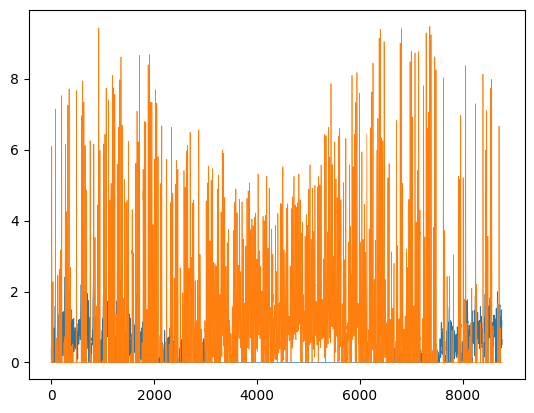

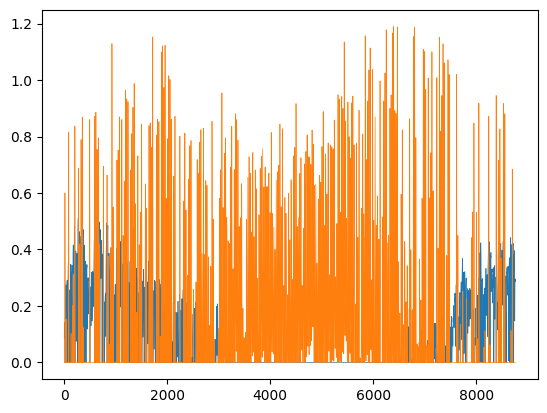

In [73]:
fig = plt.figure()
plt.plot(results[0,0,:]*2.777e-7, linewidth=0.5)
plt.plot(results[0,1,:]*2.777e-7, linewidth=0.5)
fig = plt.figure()
plt.plot(results[0,2,:]*2.777e-7, linewidth=0.5)
plt.plot(results[0,3,:]*2.777e-7, linewidth=0.5)